In [1]:
import torch
from torch.nn.functional import relu, dropout
from collections import namedtuple
import numpy as np
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug
import torchvision

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
aug = MNISTAug()
dm = DataManager()
dm.load()

In [4]:
aug.max_objects = 10
aug.min_objects = 4
aug.spacing = 1
aug.scaling_mean = 1
aug.scaling_sd = 0.25
aug.overflow = 0

In [5]:
x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 10)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 2)

In [6]:
x_train = torch.tensor(x_train.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')
x_test = torch.tensor(x_test.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')

/Users/akhildevarashetti/code/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[{'class': 3,
  'class_one_hot': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  'x1': 57,
  'y1': 62,
  'x2': 87,
  'y2': 92,
  'cx': 72.0,
  'cy': 77.0,
  'height': 30,
  'width': 30},
 {'class': 4,
  'class_one_hot': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  'x1': 20,
  'y1': 4,
  'x2': 56,
  'y2': 40,
  'cx': 38.0,
  'cy': 22.0,
  'height': 36,
  'width': 36},
 {'class': 1,
  'class_one_hot': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'x1': 17,
  'y1': 68,
  'x2': 51,
  'y2': 102,
  'cx': 34.0,
  'cy': 85.0,
  'height': 34,
  'width': 34},
 {'class': 2,
  'class_one_hot': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  'x1': 71,
  'y1': 22,
  'x2': 109,
  'y2': 60,
  'cx': 90.0,
  'cy': 41.0,
  'height': 38,
  'width': 38},
 {'class': 7,
  'class_one_hot': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
  'x1': 35,
  'y1': 44,
  'x2': 61,
  'y2': 70,
  'cx': 48.0,
  'cy': 57.0,
  'height': 26,
  'width': 26}]

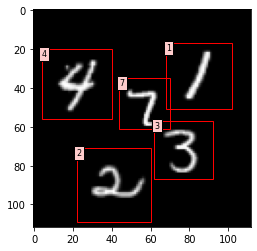

In [7]:
test_index = 3
DataManager.plot_num(x_train[test_index].reshape((112, 112)), y_train[test_index])
y_train[test_index]

In [8]:
def to_one_hot(x, num_classes=10):
  b = np.zeros((len(x), num_classes), dtype=np.float32)
  b[np.arange(len(x)), x] = 1
  return b

In [9]:
img_width = 112
n_anchors_row = 4
n_anchors = n_anchors_row ** 2
anchor_width = 28
anchor_grid_spacing = img_width / n_anchors_row

anchor_centers = []
for i in range(n_anchors_row):
  anchor_row = []
  for j in range(n_anchors_row):
    anchor_row.append([
      j * anchor_grid_spacing + anchor_grid_spacing / 2,
      i * anchor_grid_spacing + anchor_grid_spacing / 2,
    ])
  anchor_centers.append(anchor_row)
anchor_centers = torch.tensor(anchor_centers).reshape((-1, 2))

In [10]:
def get_fractional_difference(anchor, bounding_box):
  a_box = anchor
  b_box = bounding_box

  cx_d = (b_box['cx'] - a_box[0]) / img_width
  cy_d = (b_box['cy'] - a_box[1]) / img_width
  wd = (b_box['width'] - anchor_width) / img_width

  return cx_d, cy_d, wd

def get_units_from_diff(anchors, bounding_boxes):
    diffs = torch.zeros((len(anchors), 3)).to(device)
    for i in range(len(anchors)):
        diffs[i][0] = bounding_boxes[i][0] * img_width + anchors[i][0]
        diffs[i][1] = bounding_boxes[i][1] * img_width + anchors[i][1]
        diffs[i][2] = bounding_boxes[i][2] * img_width + anchor_width

    return diffs

In [11]:
def get_iou(anchor_center, bounding_box):

    half_anchor_width = anchor_width / 2
    boxA = [
        anchor_center[0]-half_anchor_width,
        anchor_center[1]-half_anchor_width,
        anchor_center[0]+half_anchor_width,
        anchor_center[1]+half_anchor_width
    ]
    boxB = [bounding_box['x1'], bounding_box['y1'], bounding_box['x2'], bounding_box['y2']]

    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [12]:
def get_positive_anchors(y_batch):
    """
    1. For Each item in the batch:
    2. For each anchor box:
    - For each bounding box:
        - Find the IoU.
    - Pick bounding box with highest IoU for that anchor.
    - # TODO: Pick the anchor with the highest IoU for that bounding box.
    - If highest IoU is < 0.3, then continue 1.
    # - Create the difference units for the anchor and the bounding box as y
    - Now add the anchor box and bounding box into a map.
    """
    all_positive_pairs = []
    for batch_i in range(len(y_batch)):
        positive_pairs_batch = []
        max_iou_b = {}
        max_iou_a = {}

        # ---------- The two loops --------------

        for anchor_i in range(len(anchor_centers)):
            for bb_i in range(len(y_batch[batch_i])):

                b_box = y_batch[batch_i][bb_i]
                a_box = anchor_centers[anchor_i]

                iou = get_iou(a_box, b_box)
                default_iou = {'iou': 0, 'bb_i': -1, 'ab_i': -1}

                # --------------- Find max IoUs ------------------

                if iou > max_iou_b.get(bb_i, default_iou)['iou']:
                    max_iou_b[bb_i] = {
                        'iou': iou,
                        'bb_i': bb_i,
                        'ab_i': anchor_i
                    }

                if iou > 0.5 and iou > max_iou_a.get(anchor_i, default_iou)['iou']:
                    max_iou_a[anchor_i] = {
                        'iou': iou,
                        'bb_i': bb_i,
                        'ab_i': anchor_i
                    }

        # --------- Merge both max ious ----------------

        positive_pairs = [max_iou_b[index] for index in list(max_iou_b.keys())]
        for index in list(max_iou_a.keys()):
            if max_iou_a[index] not in positive_pairs:
                positive_pairs.append(max_iou_a[index])
        all_positive_pairs.append(positive_pairs)

    return all_positive_pairs

In [13]:
positives = get_positive_anchors(y_test[:2])
for positive in positives:
  print(len(positive))
n_anchors

7
7


16

In [14]:
def get_y_d(y):
  """
  Find all the positive anchor pairs.
  for each of y:
    for each pair in yi:
      find fractional difference in anchor and bounding box.
      append the fractional difference to the pair.
  """
  y_d = []
  positive_pairs = get_positive_anchors(y)
  for yi in range(len(y)):
    diffs = []
    for pair_i in range(len(y[yi])):
      pair = positive_pairs[yi][pair_i]
      anchor = anchor_centers[pair['ab_i']]
      bounding_box = y[yi][pair['bb_i']]
      cx_d, cy_d, wd = get_fractional_difference(anchor, bounding_box)
      diffs.append((cx_d, cy_d, wd, pair['ab_i'], pair['bb_i']))
    y_d.append(torch.tensor(diffs))
  return y_d

In [15]:
y_train_d = get_y_d(y_train)
y_test_d = get_y_d(y_test)

In [16]:
is_training = True
drop_p = 0.3


class BoxPredictor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(1024, 512)
    self.linear2 = torch.nn.Linear(512, 3 * n_anchors)

  def forward(self, x):
    x = dropout(relu(self.linear1(x)), drop_p, is_training)
    x = torch.tanh(self.linear2(x))
    return x.reshape((-1, n_anchors, 3))


class ConfidencePredictor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(1024, 512)
    self.linear2 = torch.nn.Linear(512, n_anchors)

  def forward(self, x):
    x = dropout(torch.relu(self.linear1(x)), drop_p, is_training)
    x = torch.sigmoid(self.linear2(x))
    return x


class DetectorV1 (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(10, 20, 3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(20, 40, 3, stride=2)
        self.conv4 = torch.nn.Conv2d(40, 80, 3, stride=2, padding=1)
        self.conv5 = torch.nn.Conv2d(80, 160, 3, stride=2)
        self.linear1 = torch.nn.Linear(5760, 1024)
        self.box_predictor = BoxPredictor()
        self.confidence_predictor = ConfidencePredictor()

    def forward(self, x):
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = relu(self.conv3(x))
        x = relu(self.conv4(x))
        x = relu(self.conv5(x))
        x = torch.flatten(x, 1)
        x = dropout(relu(self.linear1(x)), drop_p, is_training)
        boxes = self.box_predictor(x)
        confidences = self.confidence_predictor(x)
        return boxes, confidences

model = DetectorV1().to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

Steps:
 - get the predictions.
 - Find the anchors which have >0.1 IoU -> +ve anchors
 - Find the matching bounding box for each +ve anchor
 - All +ve anchors are high confidence, rest are low.
 - What is the loss for -ve anchors?


 - For each of the positive anchors, Find loss and add it to the total loss.
 - Find loss of the confidences.
 -


In [18]:
epochs = 50
batch_size = 16
is_training = True

for epoch in range(epochs):

    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size

        x_batch = x_train[start_index:end_index].to(device)
        y_batch = y_train_d[start_index:end_index]

        optimizer.zero_grad()

        y_hat_boxes, y_hat_confidences = model(x_batch)

        loss = 0
        for batch_i in range(len(y_batch)):  # Each image
            y_diffs = y_batch[batch_i]
            """
            1. find losses for each positive anchor
            2. Sum them all up.
            3. Create an array of n_anchors length for target confidences.
            4. Make confidences 1 for positive indices.
            5. Find losses for confidences.
            """
            y_confidences = torch.zeros((n_anchors)).to(device)
            for anchor_i in range(len(y_batch[batch_i])):  # Each positive anchor
                box_index = int(y_batch[batch_i][anchor_i][4])
                yd_box = y_batch[batch_i][anchor_i][:3].to(device)

                anchor_index = int(y_batch[batch_i][anchor_i][3])
                yd_pred = y_hat_boxes[batch_i][anchor_index]

                loss += sum((yd_box - yd_pred) ** 2)

                y_confidences[anchor_index] = 1.0

            loss += sum((y_confidences - y_hat_confidences[batch_i]) ** 2)

        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch}\tloss: {float(loss)}')

Epoch: 0	loss: 41.07500457763672
Epoch: 1	loss: 40.39043426513672
Epoch: 2	loss: 39.48320007324219
Epoch: 3	loss: 38.52090072631836
Epoch: 4	loss: 37.574928283691406
Epoch: 5	loss: 37.55823516845703
Epoch: 6	loss: 37.335899353027344
Epoch: 7	loss: 36.6142578125
Epoch: 8	loss: 36.78982925415039
Epoch: 9	loss: 36.39814376831055
Epoch: 10	loss: 36.41496276855469
Epoch: 11	loss: 35.88568115234375
Epoch: 12	loss: 36.23936462402344
Epoch: 13	loss: 35.98857498168945
Epoch: 14	loss: 35.32118225097656
Epoch: 15	loss: 35.29656219482422
Epoch: 16	loss: 35.2900276184082
Epoch: 17	loss: 35.007442474365234
Epoch: 18	loss: 34.75886917114258
Epoch: 19	loss: 33.280670166015625
Epoch: 20	loss: 32.8172607421875
Epoch: 21	loss: 31.933582305908203
Epoch: 22	loss: 31.392635345458984
Epoch: 23	loss: 29.35795783996582
Epoch: 24	loss: 27.215782165527344
Epoch: 25	loss: 25.52549934387207
Epoch: 26	loss: 21.456350326538086
Epoch: 27	loss: 19.00537872314453
Epoch: 28	loss: 14.395149230957031
Epoch: 29	loss: 11.26

- get predictions
- get all anchor indices where confidences are > 0
- Find the coordinates of the boxes.
- Do nms on those.
- plot them.

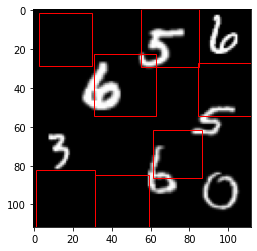

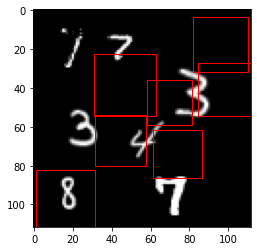

In [19]:
with torch.no_grad():
    is_training = False
    y_hat_boxes, y_hat_confidences = model(x_test.to(device))
    for batch_i in range(len(x_test)):
        positive_indices = (y_hat_confidences[batch_i] > 0.7).nonzero().reshape((-1))

        pred_boxes = y_hat_boxes[batch_i][positive_indices]
        anchors = anchor_centers[positive_indices]
        pred_confidences = y_hat_confidences[batch_i][positive_indices]
        pred_boxes = get_units_from_diff(anchors, pred_boxes)

        pred_boxes = torch.tensor([[
            float(box[0] - box[2] / 2),
            float(box[1] - box[2] / 2),
            float(box[0] + box[2] / 2),
            float(box[1] + box[2] / 2)
         ] for box in pred_boxes]).to(device)

        #keep_indices = torchvision.ops.nms(pred_boxes, pred_confidences, 0.1)
        #pred_boxes = pred_boxes[keep_indices]

        DataManager.plot_num(
            x_test[batch_i].reshape((img_width, img_width)),
            [{'x1': box[0], 'y1': box[1], 'x2': box[2], 'y2': box[3]} for box in pred_boxes] # + y_test[batch_i]
        )
